# Hotspot analysis

## From TRAMS data

### A) Severity & frequency (core)

- Total crash count

- Severity-weighted sum (“weight”)

- Fatalities, serious injuries, minor injuries (counts)

- % FSI (fatal+serious) of all casualties

- Average severity per crash (weight ÷ crash count)

### B) Road-user composition (core)

- Motorcycle-involved crashes (count, % of all crashes)

- Pedestrian-involved, bicycle-involved (count, %)

- Heavy vehicle (truck/bus) involvement (count, %)

- Single-vehicle vs multi-vehicle (count, %)

### C) Crash type & manoeuvre (core if available)

- Collision type distribution (rear-end, angle, head-on, sideswipe, run-off-road, rollover, etc.)

- Junction-related vs mid-block (and junction subtype: T, cross, roundabout, U-turn)

- Turning/U-turn, overtaking, lane change, reversing (count, %)

### D) Temporal patterns (core)

- Hour of day (day/night; peak vs off-peak)

- Day of week (weekday/weekend)

- Month/season; major holiday periods (e.g., Songkran)

### E) Conditions at crash (core if coded)

- Weather (clear, rain, fog, etc.)

- Lighting (daylight, dark-lit, dark-unlit)

- Road surface (dry, wet, loose/gravel, flooded)

- Work-zone / temporary control present (yes/no)

### F) Contributory factors & compliance (nice-to-have, if coded)

- Speeding suspected/primary cause (yes/no, %)

- Alcohol/drug involvement (yes/no, %)

- Helmet use (for riders/pillion), seatbelt use (for car occupants)

- Mobile phone/distraction noted (yes/no)

### G) Person/vehicle descriptors (nice-to-have)

Driver/rider age group, sex (distribution)

Vehicle age/class (scooter vs motorcycle, pickup, sedan, truck, bus)

### H) Location/context (often in TRAMS; useful if present)

Urban vs rural flag / municipality category

Near school/market/hospital (POI flags)

Curve/grade present; speed limit category; lane count / divided vs undivided (if encoded in the crash record)

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd

In [31]:
import geopandas as gpd
accidents = gpd.read_file("DOH/motorcycle_accidents_TRAMS.shp")
lixels_100 = gpd.read_file("roadnetwork/hotspot_top1.gpkg", layer="lixels100_bw200")

In [35]:
# hotspot or non-hotspot
hotspots = lixels_100[lixels_100['is_hot']==True]

## Hotspot and Non-hotspot features

In [34]:
lixels_100.columns

Index(['osm_id', 'code', 'fclass', 'name', 'ref', 'oneway', 'maxspeed',
       'layer', 'bridge', 'tunnel', 'is_numbered', 'owner',
       'selected_by_distance', 'length_m', 'len_m', 'parent_id', 'order',
       'lixel_len_m', 'nkde_sample_id', 'density_bw100', 'density_bw200',
       'density_bw300', 'is_hot', 'geometry'],
      dtype='object')

In [30]:
len(hotspots['fclass'].unique())

8

In [91]:
import geopandas as gpd
import pandas as pd
import numpy as np

# Your hotspots/lixels GDF (lines) with is_hot etc.
L = lixels_100.to_crs(epsg=3857).copy()  # keep CRS consistent with your pipeline
# L = L.explode(index_parts=False).reset_index(drop=True)  # handle MultiLineString

# Province polygons (make sure it has stable codes, e.g., 'prov_code', 'prov_name')
prov = gpd.read_file("/Users/stupong/Desktop/ThaiRAP/osm/tha_adm_rtsd_itos_20210121_shp/tha_admbnda_adm1_rtsd_20220121.shp")  # or shapefile
prov = prov.to_crs(L.crs).copy()
prov = prov.explode(index_parts=False).reset_index(drop=True)

# # (optional) fix invalid geometries
# prov["geometry"] = prov["geometry"].buffer(0)
# L["geometry"]    = L["geometry"].buffer(0)


In [92]:
print(L.crs)
print(prov.crs)

EPSG:3857
EPSG:3857


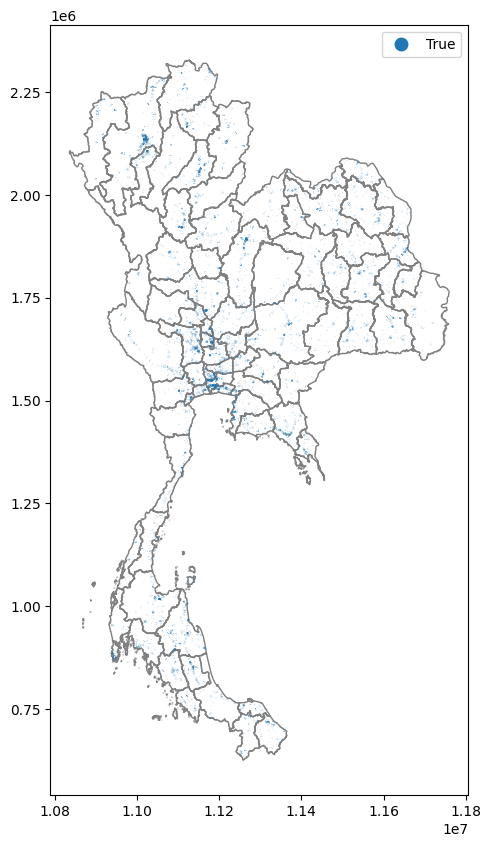

In [93]:
# plot both L and prov to check alignment
ax = prov.plot(facecolor="none", edgecolor="gray", figsize=(10,10))
L[L["is_hot"]==True].plot(ax=ax, column="is_hot", legend=True);

In [72]:
L.columns

Index(['osm_id', 'code', 'fclass', 'name', 'ref', 'oneway', 'maxspeed',
       'layer', 'bridge', 'tunnel', 'is_numbered', 'owner',
       'selected_by_distance', 'length_m', 'len_m', 'parent_id', 'order',
       'lixel_len_m', 'nkde_sample_id', 'density_bw100', 'density_bw200',
       'density_bw300', 'is_hot', 'geometry'],
      dtype='object')

In [ ]:
# --- Inputs ---
# L   : your lixel GeoDataFrame (LineString/MultiLineString), metric CRS (e.g., EPSG:3857)
# prov: province polygons with fields ADM1_PCODE, ADM1_EN

L = L.copy()
prov = prov.copy()

# 1) Same CRS (project provinces to L)
if L.crs is None or L.crs.is_geographic:
    raise ValueError("L must be in a metric CRS (e.g., EPSG:3857) before spatial ops.")
if prov.crs != L.crs:
    prov = prov.to_crs(L.crs)

# 2) Clean + unique ID
L = L.explode(index_parts=False).reset_index(drop=True)
if "nkde_sample_id" in L.columns:
    L = L.drop(columns=["nkde_sample_id"])
L["nkde_sample_id"] = np.arange(len(L), dtype=int)

# 3) Midpoint for each lixel
mid = L.copy()
mid["midpoint"] = mid.geometry.interpolate(0.5, normalized=True)
mid = mid.set_geometry("midpoint")

# 4) Join midpoint to provinces (within); fallback to nearest for any misses
j = gpd.sjoin(
    mid[["nkde_sample_id", "midpoint"]],
    prov[["ADM1_PCODE", "ADM1_EN", "geometry"]],
    how="left",
    predicate="within",
).drop(columns="index_right")

miss = j["ADM1_PCODE"].isna()
if miss.any():
    j_near = gpd.sjoin_nearest(
        mid.loc[miss, ["nkde_sample_id", "midpoint"]],
        prov[["ADM1_PCODE", "ADM1_EN", "geometry"]],
        how="left",
    ).drop(columns="index_right")
    j.loc[miss, ["ADM1_PCODE", "ADM1_EN"]] = j_near[["ADM1_PCODE", "ADM1_EN"]].to_numpy()

# 5) Merge back to line geometry; keep province columns
L_prov = (
    L.drop(columns=[c for c in ["ADM1_PCODE", "ADM1_EN"] if c in L.columns])
      .merge(j[["nkde_sample_id", "ADM1_PCODE", "ADM1_EN"]],
             on="nkde_sample_id", how="left")
)

# (optional) quick sanity check
assigned = L_prov["ADM1_PCODE"].notna().mean()
print(f"Assigned provinces for {assigned:.1%} of lixels (midpoint-based).")


Assigned provinces for 100.0% of lixels (midpoint-based).


In [221]:
print("L CRS:", L.crs, "prov CRS:", prov.crs)
print("L bounds:", L.total_bounds, "prov bounds:", prov.total_bounds)
print("prov geom types:", prov.geom_type.value_counts().to_dict())


L CRS: EPSG:3857 prov CRS: EPSG:3857
L bounds: [10874890.45627795   630961.49709024 11759057.18931811  2326023.71089296] prov bounds: [10836213.09709882   625842.38994213 11759453.09909088  2328207.45732293]
prov geom types: {'Polygon': 803}


In [203]:
import numpy as np, pandas as pd, geopandas as gpd

dens_col   = "density_bw200"
FRAC       = 0.01     # top 1% rows as hotspots
FRINGE_M   = 25       # exclude near-hot from controls
STRATA     = ("ADM1_PCODE","fclass")
rng        = np.random.default_rng(42)

G = G.copy()
if "lixel_id" not in G.columns:
    G = G.reset_index(drop=True)
    G["lixel_id"] = np.arange(len(G), dtype=int)

# 1) Label hotspots by rows (top K)
K = int(np.ceil(FRAC * len(G)))
G[dens_col] = pd.to_numeric(G[dens_col], errors="coerce")
G = G.sort_values([dens_col, "lixel_id"], ascending=[False, True]).copy()
hot_ids = set(G.iloc[:K]["lixel_id"])
G["is_hot_rows"] = G["lixel_id"].isin(hot_ids)

# 2) Strict non-hot = complement minus 75 m buffer
if G["is_hot_rows"].any():
    hot_union = gpd.GeoSeries(G.loc[G["is_hot_rows"], "geometry"], crs=G.crs).buffer(FRINGE_M).union_all()
    G["is_fringe"] = G.geometry.intersects(hot_union)
else:
    G["is_fringe"] = False
G["is_nonhot_strict"] = (~G["is_hot_rows"]) & (~G["is_fringe"])

# 3) Build negative subsets
pool = G[G["is_nonhot_strict"]].copy()
pool["is_zero"] = pool[dens_col].fillna(0) <= 0

# (a) Hard negatives: K rows immediately below hotspot cutoff
hard_pool = pool.sort_values([dens_col, "lixel_id"], ascending=[False, True]).copy()
hard_neg_ids = set(hard_pool.head(K)["lixel_id"])
G["is_neg_hard"] = G["lixel_id"].isin(hard_neg_ids)

# (b) Low-but-nonzero negatives: pick K from lowest nonzero decile
nz = pool[~pool["is_zero"]]
if not nz.empty:
    q10 = nz[dens_col].quantile(0.10)
    low_pool = nz[nz[dens_col] <= q10]
    take = min(K, len(low_pool))
    low_ids = set(rng.choice(low_pool.index.to_numpy(), size=take, replace=False))
    G["is_neg_low"] = G.index.isin(low_ids)
else:
    G["is_neg_low"] = False

# (c) Zero-only negatives: pick K zeros
zero_pool = pool[pool["is_zero"]]
take = min(K, len(zero_pool))
zero_ids = set(rng.choice(zero_pool.index.to_numpy(), size=take, replace=False)) if take>0 else set()
G["is_neg_zero"] = G.index.isin(zero_ids)

# 4) Stratified, row-matched control (Province × fclass) from strict pool

def stratified_row_match_exact(G, hot_mask, pool_mask, strata=("ADM1_PCODE","fclass"),
                               n_target=None, random_state=42, verbose=True):
    """
    Return a boolean mask column 'is_ctrl_rows_matched' selecting exactly n_target rows
    (if pool has enough rows). Respects strata shares of hot, clamps by available pool
    per stratum, reallocates deficits to strata with remaining capacity, and finally
    fills any remaining shortfall from the global pool.
    """
    rng  = np.random.default_rng(random_state)
    X    = G.copy()
    hot  = X[hot_mask]
    pool = X[pool_mask].copy()

    if n_target is None:
        n_target = len(hot)

    # quick guard: if pool too small, we can’t reach target
    if len(pool) < n_target:
        if verbose:
            print(f"[WARN] Pool size {len(pool)} < target {n_target}. Will sample {len(pool)}.")
        chosen_idx = pool.index.to_numpy()
        X["is_ctrl_rows_matched"] = X.index.isin(chosen_idx)
        return X

    # hotspot strata shares
    if strata:
        hot_counts  = hot.groupby(list(strata), dropna=False).size()
        hot_shares  = hot_counts / hot_counts.sum()

        pool_counts = pool.groupby(list(strata), dropna=False).size()

        # align to pool strata (drop strata with no pool)
        hot_shares = hot_shares.reindex(pool_counts.index).fillna(0)
        # initial quotas
        quotas = n_target * hot_shares
        base   = np.floor(quotas).astype(int)

        # clamp by available capacity
        assigned = np.minimum(base, pool_counts)

        remaining = int(n_target - assigned.sum())
        capacity  = (pool_counts - assigned).clip(lower=0)

        # priority = larger remainder first (where capacity > 0)
        remainder = (quotas - base).reindex(capacity.index).fillna(0)

        # reallocate greedily until filled or no capacity
        while remaining > 0 and int(capacity.sum()) > 0:
            # pick stratum with highest remainder that still has capacity
            cand = remainder.copy()
            cand[capacity <= 0] = -1  # exclude full strata
            if (cand <= 0).all():
                # fallback: distribute proportional to capacity
                probs = (capacity / capacity.sum()).to_numpy()
                keys  = list(capacity.index)
                k     = rng.choice(len(keys), p=probs)
                key   = keys[k]
            else:
                key = cand.idxmax()
            assigned[key] += 1
            capacity[key] -= 1
            remaining -= 1

        # sample rows per stratum based on assigned counts
        chosen = []
        for key, ct in assigned.items():
            if ct <= 0: 
                continue
            if not isinstance(key, tuple):
                key = (key,)
            mask = np.logical_and.reduce([
                pool[c].eq(v) if pd.notna(v) else pool[c].isna()
                for c, v in zip(strata, key)
            ])
            sub = pool.loc[mask]
            take = min(int(ct), len(sub))
            if take > 0:
                picks = rng.choice(sub.index.to_numpy(), size=take, replace=False)
                chosen.extend(picks.tolist())
                pool = pool.drop(index=picks)  # remove so we don't reuse them

        # if still short, fill from remaining pool globally
        deficit = n_target - len(chosen)
        if deficit > 0:
            extra = rng.choice(pool.index.to_numpy(), size=min(deficit, len(pool)), replace=False)
            chosen.extend(extra.tolist())
            deficit -= len(extra)
            if verbose and deficit > 0:
                print(f"[WARN] Could not fully meet target; short by {deficit} after global fill.")
        chosen_idx = np.array(chosen, dtype=int)

    else:
        # unstratified: simple random sample of n_target rows from pool
        chosen_idx = rng.choice(pool.index.to_numpy(), size=n_target, replace=False)

    X["is_ctrl_rows_matched"] = X.index.isin(chosen_idx)
    if verbose:
        print(f"Controls selected: {X['is_ctrl_rows_matched'].sum()} (target {n_target})")
    return X


In [ ]:
G = stratified_row_match_exact(
        G,
        hot_mask = G["is_hot_rows"],
        pool_mask= G["is_nonhot_strict"],           # strict pool (excludes 25 m fringe)
        strata   = ("fclass","ADM1_PCODE"),         # adjust if needed
        n_target = G["is_hot_rows"].sum(),
        random_state=42,
        verbose=True
)
print("hot =", G["is_hot_rows"].sum(),
      "ctrl =", G["is_ctrl_rows_matched"].sum(),
      "pool =", G["is_nonhot_strict"].sum())


KeyError: 'f'

zero in ctrl: 11741


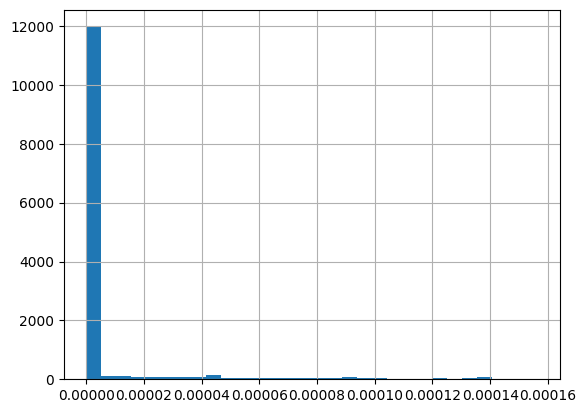

In [218]:
ctrl['density_bw200'].hist(bins=30) 
# how many in ctrl are zero?
print("zero in ctrl:", ctrl[ctrl['density_bw200'] == 0].shape[0])


In [252]:

def ensure_lixel_id(G):
    X = G.copy()
    if "lixel_id" not in X.columns:
        X = X.reset_index(drop=True)
        X["lixel_id"] = np.arange(len(X), dtype=int)
    return X

def num_col(df, name, aliases=()):
    """Return float Series for df[name] (or aliases). If missing, return aligned zeros."""
    cols = [name, *aliases]
    for c in cols:
        if c in df.columns:
            return pd.to_numeric(df[c], errors="coerce").astype(float).fillna(0.0)
    return pd.Series(0.0, index=df.index, dtype="float64")

def ensure_hot_and_pool(G, dens_col, p=0.01, fringe_m=75, by_length=True):
    """Add hotspot mask and strict non-hot pool to G.
    - Hotspots = top p by cumulative length (if by_length=True) else by rows.
    - Strict non-hot = complement minus a fringe buffer around hotspot lines.
    """
    X = ensure_lixel_id(G)
    X = X.copy()
    X[dens_col] = pd.to_numeric(X[dens_col], errors="coerce").fillna(0)

    # Ensure length
    if "len_m" not in X.columns:
        X["len_m"] = X.geometry.length

    # Sort by density desc (stable by lixel_id)
    X = X.sort_values([dens_col, "lixel_id"], ascending=[False, True]).copy()

    if by_length:
        X["cum_len"] = X["len_m"].cumsum()
        cut = p * float(X["len_m"].sum())
        X["is_hot_rows"] = X["cum_len"] <= cut
    else:
        K = int(np.ceil(p * len(X)))
        hot_ids = set(X.iloc[:K]["lixel_id"])
        X["is_hot_rows"] = X["lixel_id"].isin(hot_ids)

    # Fringe buffer to avoid kernel bleed
    if X["is_hot_rows"].any():
        buf = gpd.GeoSeries(X.loc[X["is_hot_rows"], "geometry"], crs=X.crs).buffer(fringe_m)
        try:
            hot_union = buf.union_all()
        except Exception:
            hot_union = unary_union(buf.geometry)
        X["is_fringe"] = X.geometry.intersects(hot_union)
    else:
        X["is_fringe"] = False

    X["is_nonhot_strict"] = (~X["is_hot_rows"]) & (~X["is_fringe"])
    return X

def build_near_miss_controls(
    G, dens_col, hot_col="is_hot_rows", p=0.01, band=0.02,
    strata=None, target_n=None, min_gap_m=75, random_state=42, by_length=True
):
    """Near-miss controls from the (p, p+band] band by cumulative length.
    Stratified to match hotspot composition (province × class) if strata provided.
    """
    rng = np.random.default_rng(random_state)
    X = ensure_lixel_id(G).copy()
    X[dens_col] = pd.to_numeric(X[dens_col], errors="coerce").fillna(0)
    if "len_m" not in X.columns:
        X["len_m"] = X.geometry.length

    # rank & cumulative length
    X = X.sort_values([dens_col, "lixel_id"], ascending=[False, True]).copy()
    X["cum_len"] = X["len_m"].cumsum()
    total_len = float(X["len_m"].sum())
    cut_lo = p * total_len
    cut_hi = (p + band) * total_len

    near = X[(X["cum_len"] > cut_lo) & (X["cum_len"] <= cut_hi) & (~X[hot_col])].copy()

    # keep gap from hotspots
    if min_gap_m and X[hot_col].any():
        buf = gpd.GeoSeries(X.loc[X[hot_col], "geometry"], crs=X.crs).buffer(min_gap_m)
        try:
            hot_union = buf.union_all()
        except Exception:
            hot_union = unary_union(buf.geometry)
        near = near[~near.geometry.intersects(hot_union)]

    if target_n is None:
        target_n = int(X[hot_col].sum())

    # Stratified sampling (province × class) if possible
    if strata is not None:
        if isinstance(strata, str): strata = (strata,)
        strata = tuple([c for c in strata if c in X.columns])
    else:
        strata = tuple()
    chosen_idx = []

    if len(strata) > 0 and len(near) > 0:
        hot = X[X[hot_col]]
        hot_counts = hot.groupby(list(strata), dropna=False).size()
        hot_shares = hot_counts / hot_counts.sum()

        pool_counts = near.groupby(list(strata), dropna=False).size()
        hot_shares = hot_shares.reindex(pool_counts.index).fillna(0.0)

        quotas = (hot_shares * target_n)
        base   = np.floor(quotas).astype(int)

        used = set()
        for key, ct in base.items():
            if ct <= 0: continue
            if not isinstance(key, tuple): key = (key,)
            mask = np.logical_and.reduce([
                near[c].eq(v) if pd.notna(v) else near[c].isna()
                for c, v in zip(strata, key)
            ])
            sub = near.loc[mask]
            take = min(int(ct), len(sub))
            if take > 0:
                picks = rng.choice(sub.index.to_numpy(), size=take, replace=False)
                chosen_idx.extend(picks.tolist())
                used.update(picks.tolist())

        # Top-up globally
        need = target_n - len(chosen_idx)
        rest = near.drop(index=list(used))
        if need > 0 and len(rest) > 0:
            extra = rng.choice(rest.index.to_numpy(), size=min(need, len(rest)), replace=False)
            chosen_idx.extend(extra.tolist())
    else:
        if len(near) > 0:
            chosen_idx = rng.choice(near.index.to_numpy(), size=min(target_n, len(near)), replace=False).tolist()

    out = G.copy()
    out["is_ctrl_rows_matched"] = False
    if chosen_idx:
        out.loc[chosen_idx, "is_ctrl_rows_matched"] = True
    return out

def snap_crashes_to_lixels(accidents, G, max_dist=25):
    """Nearest snap crashes to lixels; build severity weights robustly."""
    cr = accidents.copy()
    if cr.crs != G.crs:
        cr = cr.to_crs(G.crs)

    fa = num_col(cr, "Fatalities",  aliases=("Fatality","Deaths"))
    si = num_col(cr, "SeriousInj",  aliases=("SeriousInjuries","Serious_Injuries"))
    mi = num_col(cr, "MinorInjur",  aliases=("MinorInjuries","Minor_Injuries"))

    cr["weight"] = (6*fa + 4*si + 2*mi).astype(float)
    cr.loc[~np.isfinite(cr["weight"]) | (cr["weight"] <= 0), "weight"] = 1.0

    joined = gpd.sjoin_nearest(
        cr[["weight","geometry"]],
        G[["lixel_id","geometry"]],
        how="left",
        max_distance=max_dist,
        distance_col="dist_m"
    ).rename(columns={"lixel_id":"_lixel_id"})

    cr = cr.join(joined[["_lixel_id","dist_m"]])
    cr = cr[cr["_lixel_id"].notna()].copy()
    cr["lixel_id"] = cr["_lixel_id"].astype(int)
    cr = cr.drop(columns=["_lixel_id"])
    return cr

def build_lixel_crash_agg(G, accidents, max_dist=25):
    cr = snap_crashes_to_lixels(accidents, G, max_dist=max_dist)

    # time flags
    acc_date = pd.to_datetime(cr.get("AccidentDa"), errors="coerce")
    acc_time = pd.to_datetime(cr.get("AccidentTi"), format="%H:%M", errors="coerce")
    cr["hour"] = acc_time.dt.hour
    cr["is_night"]   = cr["hour"].between(22,23) | cr["hour"].between(0,5)
    cr["weekday"]    = acc_date.dt.weekday
    cr["is_weekend"] = cr["weekday"].isin([5,6])

    # vehicle flags
    mc   = (num_col(cr, "Motorcycle")  > 0).astype(int)
    t6   = (num_col(cr, "Truck6Whee")  > 0).astype(int)
    t10  = (num_col(cr, "TruckUpTo1")  > 0).astype(int)
    t10p = (num_col(cr, "TruckOver1")  > 0).astype(int)
    bus  = (num_col(cr, "BusOver4Wh")  > 0).astype(int)
    ped  = (num_col(cr, "Pedestrian")  > 0).astype(int)

    cr["is_mc"]    = mc
    cr["is_truck"] = ((t6 | t10 | t10p) > 0).astype(int)
    cr["is_bus"]   = bus
    cr["is_ped"]   = ped

    grp = cr.groupby("lixel_id", dropna=False)
    agg = pd.DataFrame({
        "N_crash":        grp.size(),
        "W_sum":          grp["weight"].sum(),
        "W_mean":         grp["weight"].mean(),
        "share_mc":       grp["is_mc"].mean(),
        "share_truck":    grp["is_truck"].mean(),
        "share_bus":      grp["is_bus"].mean(),
        "share_ped":      grp["is_ped"].mean(),
        "share_night":    grp["is_night"].mean(),
        "share_weekend":  grp["is_weekend"].mean(),
        "years_active":   grp.apply(lambda s: pd.to_datetime(s.get("AccidentDa"), errors="coerce").dt.year.nunique()
                                    if s.get("AccidentDa").notna().any() else 0),
    }).fillna(0)

    return agg, cr


In [254]:
# Column names
DENSITY_COL   = "density_bw200"     # NKDE column to rank
PROVINCE_COL  = "ADM1_PCODE"        # province code/name on lixels
CLASS_COL     = "fclass"            # road class on lixels

# Hotspot & controls
P_HOT         = 0.01                # 1% coverage (by length, default)
FRINGE_M      = 75                  # buffer excluded from control pool
NEARMISS_BAND = 0.02                # (1%, 3%] band width for near-miss controls
SNAP_TOL_M    = 25                  # crash→lixel nearest snap tolerance
BY_LENGTH     = True                # True: top p% by length; False: by rows (similar if lixels equal)

RANDOM_STATE  = 42                  # for reproducible sampling

In [255]:
np.random.seed(RANDOM_STATE)

# Ensure lixel_id first
G = ensure_lixel_id(G)

# Hotspots and strict pool
G = ensure_hot_and_pool(G, dens_col=DENSITY_COL, p=P_HOT, fringe_m=FRINGE_M, by_length=BY_LENGTH)
print("Hotspots:", int(G["is_hot_rows"].sum()), "| Strict non-hot pool:", int(G["is_nonhot_strict"].sum()))

# Controls: near-miss band (1%, 3%] by length, stratified by province × road class
strata = []
if PROVINCE_COL in G.columns: strata.append(PROVINCE_COL)
if CLASS_COL in G.columns:    strata.append(CLASS_COL)
strata = tuple(strata) if strata else None

G = build_near_miss_controls(
    G, dens_col=DENSITY_COL, hot_col="is_hot_rows",
    p=P_HOT, band=NEARMISS_BAND, strata=strata,
    target_n=int(G["is_hot_rows"].sum()),
    min_gap_m=FRINGE_M, random_state=RANDOM_STATE, by_length=BY_LENGTH
)

print("Controls selected:", int(G["is_ctrl_rows_matched"].sum()))


Hotspots: 14370 | Strict non-hot pool: 1297311
Controls selected: 14370


In [256]:
ctrl = G[G["is_ctrl_rows_matched"] == True]
print("density_bw200 min:", ctrl["density_bw200"].min())
print("density_bw200 max:", ctrl["density_bw200"].max())

density_bw200 min: 6.651902718261921e-05
density_bw200 max: 0.00014855908668597915


In [258]:
# is_hot_rows
hotspot = G[G["is_hot_rows"] == True]
print("density_bw200 min:", hotspot["density_bw200"].min())
print("density_bw200 max:", hotspot["density_bw200"].max())

density_bw200 min: 0.00014869392808291242
density_bw200 max: 0.0027384989638973107


In [271]:
# Parameters
ZERO_TARGET = 0.20  # aim for 20% zeros among controls
dens = pd.to_numeric(G["density_bw200"], errors="coerce").fillna(0)

# Current controls & pool of zeros (strict, not fringe, not hot)
ctrl_idx = G.index[G["is_ctrl_rows_matched"]]
pool_zero = G.index[(G["is_nonhot_strict"]) & (dens == 0) & (~G["is_ctrl_rows_matched"])]

n_ctrl = len(ctrl_idx)
n_zero_goal = int(round(ZERO_TARGET * n_ctrl))
n_zero_take = min(n_zero_goal, len(pool_zero))

# If you want to preserve province×class balance, do this per-stratum instead.
if n_zero_take > 0:
    # drop that many current controls (random), add same count from zero pool (random)
    rng = np.random.default_rng(42)
    drop_idx = rng.choice(ctrl_idx.to_numpy(), size=n_zero_take, replace=False)
    add_idx  = rng.choice(pool_zero.to_numpy(), size=n_zero_take, replace=False)

    G.loc[drop_idx, "is_ctrl_rows_matched"] = False
    G.loc[add_idx,  "is_ctrl_rows_matched"] = True

# Recheck zero share
ctrl = G[G["is_ctrl_rows_matched"]]
pct_zero = 100 * (pd.to_numeric(ctrl["density_bw200"], errors="coerce").fillna(0) == 0).mean()
print(f"zeros among controls: {pct_zero:.1f}%  (target {ZERO_TARGET*100:.0f}%)")


zeros among controls: 20.0%  (target 20%)


In [260]:
G.columns

Index(['osm_id', 'code', 'fclass', 'name', 'ref', 'oneway', 'maxspeed',
       'layer', 'bridge', 'tunnel', 'is_numbered', 'owner',
       'selected_by_distance', 'length_m', 'len_m', 'parent_id', 'order',
       'lixel_len_m', 'density_bw100', 'density_bw200', 'density_bw300',
       'is_hot', 'geometry', 'nkde_sample_id', 'ADM1_PCODE', 'ADM1_EN',
       'cum_len', 'is_hot1', 'is_fringe', 'is_nonhot_strict', 'lixel_id',
       'is_hot_rows', 'is_neg_hard', 'is_neg_low', 'is_neg_zero',
       'is_ctrl_rows_matched'],
      dtype='object')

### spare

In [232]:
G = build_density_aware_controls(
    G,
    dens_col="density_bw200",
    hot_mask_col="is_hot_rows",
    strict_pool_col="is_nonhot_strict",
    strata=("ADM1_PCODE","fclass"),   # or ("fclass",) if capacity is tight
    target_n=G["is_hot_rows"].sum(),
    fringe_m=75,                     # ≥75–100 m for BW=200
    hard_prop=0.25,                   # 25% hard
    low_prop=0.70,                    # 55% low-but-nonzero
    zero_prop=0.05,                   # 5% zeros (cap zeros)
    low_quantile=0.20,                # bottom 20% of nonzero densities
    random_state=42,
    verbose=True
)

# sanity check zeros in controls
dens = pd.to_numeric(G["density_bw200"], errors="coerce").fillna(0)
mask_ctrl = G["is_ctrl_rows_matched"].fillna(False)
pct_zero = 100 * (dens[mask_ctrl].le(0)).mean()
print(f"zeros among controls: {pct_zero:.1f}%")


[targets] hard=3351, low=9383, zero=670, total=13404
[result] controls chosen = 13404 (target 13404)
zeros among controls: 27.3%


In [233]:
import numpy as np
import pandas as pd

dens = pd.to_numeric(G["density_bw200"], errors="coerce").fillna(0)
mask_ctrl = G["is_ctrl_rows_matched"].fillna(False)

# treat exact/near-zero as zero (tolerance recommended)
EPS = 0.0  # or e.g. 1e-12
mask_zero = dens <= EPS

ctrl_zero_count = int((mask_ctrl & mask_zero).sum())
ctrl_total      = int(mask_ctrl.sum())
ctrl_zero_share = 100 * ctrl_zero_count / max(ctrl_total, 1)

print(f"controls total: {ctrl_total}")
print(f"zeros in controls: {ctrl_zero_count} ({ctrl_zero_share:.1f}%)")


controls total: 13404
zeros in controls: 3655 (27.3%)


In [131]:
import contextily as ctx
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.font_manager import FontProperties

# ---------- helpers ----------
def _nice_length_m(data_width_m):
    """Pick a nice scalebar length (1/2/5 × 10^n) ~ 1/5 of axis width."""
    target = data_width_m / 5.0
    import math
    exp = int(math.floor(math.log10(target))) if target > 0 else 0
    base = target / (10 ** exp)
    for b in (1, 2, 5, 10):
        if base <= b:
            return b * (10 ** exp)
    return 10 * (10 ** exp)

def add_scalebar(ax, loc="lower left", font_size=9, pad=0.2):
    """Add a scalebar (meters) to an EPSG:3857 axis."""
    xmin, xmax = ax.get_xlim()
    length_m = _nice_length_m(xmax - xmin)
    label = f"{int(length_m/1000)} km" if length_m >= 1000 else f"{int(length_m)} m"
    fp = FontProperties(size=font_size)
    sb = AnchoredSizeBar(ax.transData, length_m, label, loc,
                         pad=pad, color='black', frameon=True,
                         size_vertical=(xmax - xmin) * 0.003,
                         fontproperties=fp)
    ax.add_artist(sb)

def add_north_arrow(ax, xy=(0.8, 0.82), size=0.08, text="N", text_size=10):
    """Add a simple north arrow in axes fraction coords."""
    ax.annotate("", xy=(xy[0], xy[1] + size), xytext=xy,
                xycoords="axes fraction", textcoords="axes fraction",
                arrowprops=dict(arrowstyle="-|>", linewidth=1.5, color="white"))
    ax.text(xy[0], xy[1] + size + 0.015, text,
            transform=ax.transAxes, ha="center", va="bottom",
            fontsize=text_size, fontweight="bold",color="white")

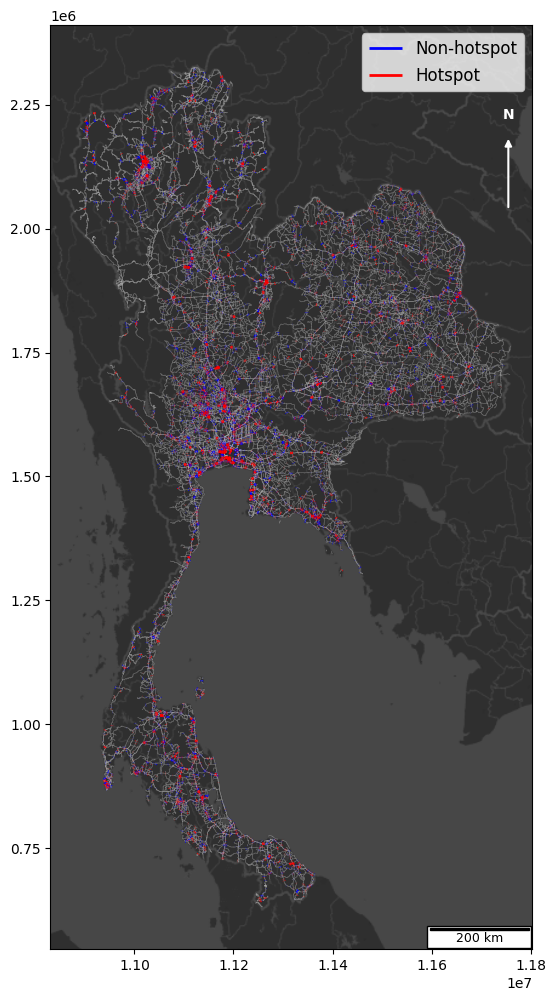

In [261]:
# Plot G with two colors: hotspot (is_hot_rows) and non-hotspot (is_ctrl_rows_matched)

tiles    = ctx.providers.CartoDB.DarkMatterNoLabels

ax = G.plot(color="lightgray", linewidth=0.5, alpha=0.5, figsize=(12, 12))
G[G["is_ctrl_rows_matched"]].plot(ax=ax, color="blue", linewidth=2, label="Non-hotspot")
G[G["is_hot_rows"]].plot(ax=ax, color="red", linewidth=2, label="Hotspot")

# scale + north arrow
add_scalebar(ax, loc="lower right")
add_north_arrow(ax, xy=(0.95, 0.80), size=0.08)

ctx.add_basemap(ax, source=tiles, attribution=False, alpha=0.85, zorder=1)

ax.legend(loc="upper right", fontsize=12, frameon=True)
#save
# ax.set_title("Hotspot vs Non-hotspot lixels")

In [270]:
# save G
G.to_file("roadnetwork/hotspot_control.gpkg", driver="GPKG", layer="lixels_hot_ctrl")

In [251]:
import numpy as np, pandas as pd, geopandas as gpd

# ====================== 0) Utilities ======================

def ensure_lixel_id(G):
    G = G.copy()
    if "lixel_id" not in G.columns:
        G = G.reset_index(drop=True)
        G["lixel_id"] = np.arange(len(G), dtype=int)
    return G

def ensure_hot_and_pool(G, dens_col="density_bw200", p=0.01, fringe_m=100):
    """Ensure hotspot mask (top p by rows) and strict non-hot pool (excluding a fringe)."""
    X = ensure_lixel_id(G)
    X[dens_col] = pd.to_numeric(X[dens_col], errors="coerce").fillna(0)
    # rank by density (stable by lixel_id)
    X = X.sort_values([dens_col, "lixel_id"], ascending=[False, True]).copy()

    K = int(np.ceil(p * len(X)))
    hot_ids = set(X.iloc[:K]["lixel_id"])
    X["is_hot_rows"] = X["lixel_id"].isin(hot_ids)

    # make len_m if missing (EPSG:3857 expected)
    if "len_m" not in X.columns:
        X["len_m"] = X.geometry.length

    # fringe buffer to keep controls clean
    if X["is_hot_rows"].any():
        buf = gpd.GeoSeries(X.loc[X["is_hot_rows"], "geometry"], crs=X.crs).buffer(fringe_m)
        try:
            hot_union = buf.union_all()
        except Exception:
            from shapely.ops import unary_union
            hot_union = unary_union(buf.geometry)
        X["is_fringe"] = X.geometry.intersects(hot_union)
    else:
        X["is_fringe"] = False

    X["is_nonhot_strict"] = (~X["is_hot_rows"]) & (~X["is_fringe"])
    return X

def snap_crashes_to_lixels(accidents, G, max_dist=25):
    """Nearest snap crashes to lixels (EPSG:3857), return copy with lixel_id + weight."""
    cr = accidents.copy()
    if cr.crs != G.crs:
        cr = cr.to_crs(G.crs)

    # severity weights
    def num(s): return pd.to_numeric(s, errors="coerce").fillna(0)
    cr["weight"] = (6*num(cr.get("Fatalities")) +
                    4*num(cr.get("SeriousInj")) +
                    2*num(cr.get("MinorInjur"))).astype(float)
    cr.loc[~np.isfinite(cr["weight"]) | (cr["weight"]<=0), "weight"] = 1.0

    joined = gpd.sjoin_nearest(
        cr[["weight","geometry"]],
        G[["lixel_id","geometry"]],
        how="left",
        max_distance=max_dist,
        distance_col="dist_m"
    ).rename(columns={"lixel_id":"_lixel_id"})

    cr = cr.join(joined[["_lixel_id","dist_m"]])
    cr = cr[cr["_lixel_id"].notna()].copy()
    cr["lixel_id"] = cr["_lixel_id"].astype(int)
    cr = cr.drop(columns=["_lixel_id"])
    return cr

def build_lixel_crash_agg(G, accidents, max_dist=25):
    """Aggregate snapped crashes to lixel level for EDA."""
    cr = snap_crashes_to_lixels(accidents, G, max_dist=max_dist)

    # simple flags
    def num(s): return pd.to_numeric(s, errors="coerce").fillna(0)
    def flag(col): return (num(cr.get(col)) > 0).astype(int)

    cr["is_mc"]    = flag("Motorcycle")
    cr["is_truck"] = (flag("Truck6Whee") | flag("TruckUpTo1") | flag("TruckOver1")).astype(int)
    cr["is_bus"]   = flag("BusOver4Wh")
    cr["is_ped"]   = flag("Pedestrian")

    cr["AccidentDate"] = pd.to_datetime(cr.get("AccidentDa"), errors="coerce")
    cr["hour"] = pd.to_datetime(cr.get("AccidentTi"), format="%H:%M", errors="coerce").dt.hour
    cr["is_night"]    = cr["hour"].between(22,23) | cr["hour"].between(0,5)
    cr["weekday"]     = cr["AccidentDate"].dt.weekday
    cr["is_weekend"]  = cr["weekday"].isin([5,6])

    grp = cr.groupby("lixel_id", dropna=False)
    agg = pd.DataFrame({
        "N_crash":        grp.size(),
        "W_sum":          grp["weight"].sum(),
        "W_mean":         grp["weight"].mean(),
        "share_mc":       grp["is_mc"].mean(),
        "share_truck":    grp["is_truck"].mean(),
        "share_bus":      grp["is_bus"].mean(),
        "share_ped":      grp["is_ped"].mean(),
        "share_night":    grp["is_night"].mean(),
        "share_weekend":  grp["is_weekend"].mean(),
        "years_active":   grp["AccidentDate"].apply(lambda s: s.dt.year.nunique() if s.notna().any() else 0),
    }).fillna(0)
    return agg, cr

# ====================== 1) Primary control recipe: Near-miss ======================

def build_near_miss_controls(
    G, dens_col="density_bw200", hot_col="is_hot_rows",
    p=0.01, band=0.02,         # controls from (1%, 3%] cumulative length
    strata=("ADM1_PCODE","fclass"),
    target_n=None, min_gap_m=100, random_state=42, verbose=True
):
    rng = np.random.default_rng(random_state)
    X = ensure_lixel_id(G)
    if isinstance(strata, str): strata = (strata,)

    X = X.copy()
    X[dens_col] = pd.to_numeric(X[dens_col], errors="coerce").fillna(0)
    if "len_m" not in X.columns:
        X["len_m"] = X.geometry.length

    # sort by density desc
    X = X.sort_values([dens_col, "lixel_id"], ascending=[False, True]).copy()
    X["cum_len"] = X["len_m"].cumsum()
    total_len = float(X["len_m"].sum())

    cut_lo = p * total_len
    cut_hi = (p + band) * total_len

    near = X[(X["cum_len"] > cut_lo) & (X["cum_len"] <= cut_hi) & (~X[hot_col])].copy()

    # keep gap from hotspots
    if min_gap_m and X[hot_col].any():
        buf = gpd.GeoSeries(X.loc[X[hot_col], "geometry"], crs=X.crs).buffer(min_gap_m)
        try:
            hot_union = buf.union_all()
        except Exception:
            from shapely.ops import unary_union
            hot_union = unary_union(buf.geometry)
        near = near[~near.geometry.intersects(hot_union)]

    # target size = number of hotspots
    if target_n is None:
        target_n = int(X[hot_col].sum())

    # stratified sampling to match hotspot composition
    hot = X[X[hot_col]]
    if strata and len(near) > 0:
        hot_counts = hot.groupby(list(strata), dropna=False).size()
        hot_shares = (hot_counts / hot_counts.sum())

        pool_counts = near.groupby(list(strata), dropna=False).size()
        hot_shares = hot_shares.reindex(pool_counts.index).fillna(0.0)

        quotas = (hot_shares * target_n)
        base   = np.floor(quotas).astype(int)

        chosen = []
        used = set()
        # sample per stratum by base, then top-up globally
        for key, ct in base.items():
            if ct <= 0: continue
            if not isinstance(key, tuple): key = (key,)
            mask = np.logical_and.reduce([
                near[c].eq(v) if pd.notna(v) else near[c].isna()
                for c, v in zip(strata, key)
            ])
            sub = near.loc[mask]
            take = min(int(ct), len(sub))
            if take > 0:
                picks = rng.choice(sub.index.to_numpy(), size=take, replace=False)
                chosen.extend(picks.tolist())
                used.update(picks.tolist())

        # top-up to reach target
        need = target_n - len(chosen)
        rest = near.drop(index=list(used))
        if need > 0 and len(rest) > 0:
            extra = rng.choice(rest.index.to_numpy(), size=min(need, len(rest)), replace=False)
            chosen.extend(extra.tolist())

        ctrl_idx = np.array(chosen, dtype=int)
    else:
        ctrl_idx = rng.choice(near.index.to_numpy(), size=min(target_n, len(near)), replace=False)

    out = G.copy()
    out["is_ctrl_rows_matched"] = False
    out.loc[ctrl_idx, "is_ctrl_rows_matched"] = True

    if verbose:
        print(f"[near-miss] controls chosen: {out['is_ctrl_rows_matched'].sum()} (target {target_n}); pool size={len(near)}")
    return out

# ====================== 2) RUN: build hotspots, pool, controls, and print checks ======================

# Config
dens_col = "density_bw200"
p_hot    = 0.01        # 1% hotspots (by rows)
fringe_m = 100         # exclude 100 m around hotspots from pool
band     = 0.02        # near-miss band = (1%, 3%]
strata   = ("ADM1_PCODE","fclass")   # relax to ("fclass",) if needed

# Ensure hotspot mask & strict pool
G = ensure_hot_and_pool(G, dens_col=dens_col, p=p_hot, fringe_m=fringe_m)

# Build near-miss controls (primary)
G = build_near_miss_controls(
    G,
    dens_col=dens_col,
    hot_col="is_hot_rows",
    p=p_hot, band=band,
    strata=strata,
    target_n=int(G["is_hot_rows"].sum()),
    min_gap_m=fringe_m,
    random_state=42,
    verbose=True
)

# Check zeros among controls
dens = pd.to_numeric(G[dens_col], errors="coerce").fillna(0)
ctrl_mask = G["is_ctrl_rows_matched"].fillna(False)
pct_zero = 100 * (dens[ctrl_mask] <= 0).mean()
print(f"zeros among controls: {pct_zero:.1f}%")

# Aggregate crashes & print crash counts by bucket
agg, cr = build_lixel_crash_agg(G, accidents, max_dist=25)

# Label buckets
lab = pd.Series("Other non-hot", index=G.index)
lab[G["is_nonhot_strict"]] = "Strict non-hot"
lab[G["is_ctrl_rows_matched"]] = "Matched control"
lab[G["is_hot_rows"]] = "Hotspot"

# Join labels to snapped crashes
cr_lab = cr.merge(G[["lixel_id"]].join(lab.rename("bucket")), on="lixel_id", how="left")

tbl = (cr_lab.groupby("bucket", dropna=False)
              .agg(N_crashes=("weight","size"),
                   W_sum=("weight","sum"))
              .reset_index())
tbl["share_events_%"] = 100 * tbl["N_crashes"] / max(len(cr_lab), 1)
tbl["share_weight_%"] = 100 * tbl["W_sum"] / max(cr_lab["weight"].sum(), 1)
print("\n=== Crashes by bucket ===")
print(tbl.sort_values("N_crashes", ascending=False).to_string(index=False))


[near-miss] controls chosen: 13404 (target 13404); pool size=19502
zeros among controls: 0.0%


AttributeError: 'numpy.float64' object has no attribute 'fillna'

# Explore Hotspot/ Non-hotspot from TRAMS

In [236]:
hotspot = G[G["is_hot_rows"]]
nonhot  = G[G["is_ctrl_rows_matched"]]

In [237]:
print(hotspot['fclass'].value_counts())
print(nonhot['fclass'].value_counts())

fclass
secondary         3963
trunk             3794
primary           2831
tertiary          1727
trunk_link         543
primary_link       337
secondary_link     188
tertiary_link       21
Name: count, dtype: int64
fclass
secondary         4301
trunk             3781
primary           2627
tertiary          1946
trunk_link         372
primary_link       236
secondary_link     138
tertiary_link        3
Name: count, dtype: int64


In [245]:
accidents

,Year,AccidentDate,AccidentTime,ReportDate,ReportTime,AccidentCode,Agency,AgencyRoute,RouteCode,Route,...,Fatalities,SeriousInjuries,MinorInjuries,TotalInjuries,Accident_1,Presumed_1,Accident_2,geometry,date,time
0,2023,12/31/2023,0:35,1/1/2024,5:43,8901506,กรมทางหลวง,ทางหลวง,4030,ถลาง - หาดราไวย์,...,0,0,1,1,None,IMPAIRMENT,LossOfControl,POINT (10944774.404 867731.435),2023-12-31,00:35:00
1,2023,12/31/2023,0:35,1/1/2024,5:43,8901506,กรมทางหลวง,ทางหลวง,4030,ถลาง - หาดราไวย์,...,0,0,1,1,"INTERSECTION_T,FLAT",IMPAIRMENT,LossOfControl,POINT (10944774.404 867731.435),2023-12-31,00:35:00
2,2024,4/12/2024,15:31,4/13/2024,5:41,9365909,กรมทางหลวง,ทางหลวง,4030,None,...,0,0,1,1,"CURVE_WIDE,FLAT,SLOPE",SPEEDING,None,POINT (10943497.103 867819.142),2024-04-12,15:31:00
3,2019,12/28/2019,11:20,12/31/2019,6:31,615793,กรมทางหลวง,ทางหลวง,4030,ถลาง - หาดราไวย์,...,0,0,1,1,"STRAIGHT,FLAT",SPEEDING,Pedestrian,POINT (10945262.916 867939.769),2019-12-28,11:20:00
4,2019,12/27/2019,8:49,12/29/2019,10:50,615402,กรมทางหลวง,ทางหลวง,4024,ตีนเขา - หาดราไวย์,...,0,0,1,1,"STRAIGHT,FLAT",SPEEDING,RearEnd,POINT (10945937.413 868833.127),2019-12-27,08:49:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29534,2024,1/11/2024,16:00,1/26/2024,14:08,8931767,กรมทางหลวงชนบท,ทางหลวงชนบท,มส.4001,แยกทางหลวงหมายเลข 1095 (กม.ที่ 198+050) - บ้าน...,...,0,0,1,1,INTERSECTION_T,OTHER_UNKNOWN,Animal,POINT (10902963.885 2224260.507),2024-01-11,16:00:00
29535,2022,02/03/2022,14:00,03/16/2022,8:27,6566157,กรมทางหลวงชนบท,ทางหลวงชนบท,มส.4015,แยกทางหลวงหมายเลข 1095 (กม.ที่ 165+800) - บ้าน...,...,0,0,1,1,"CURVE_WIDE,SLOPE",SPEEDING,None,POINT (10919790.383 2230485.111),2022-02-03,14:00:00
29536,2022,04/16/2022,19:00,04/18/2022,14:22,6566478,กรมทางหลวงชนบท,ทางหลวงชนบท,มส.4015,แยกทางหลวงหมายเลข 1095 (กม.ที่ 165+800) - บ้าน...,...,0,0,1,1,"CURVE_WIDE,SLOPE",IMPAIRMENT,None,POINT (10919642.662 2230854.714),2022-04-16,19:00:00
29537,2023,1/1/2023,14:30,1/2/2023,5:47,7536092,กรมทางหลวงชนบท,ทางหลวงชนบท,มส.5013,แยกทางหลวงชนบท มส.4015 (กม.ที่ 16+600) - บ้านป...,...,2,1,0,1,"STRAIGHT,FLAT",IMPAIRMENT,Overtake/LaneChange,POINT (10920213.953 2233149.674),2023-01-01,14:30:00


In [145]:
TRAMS_COLMAP = {
    # IDs / when & where
    "Year": "Year",
    "AccidentDate": "AccidentDa",
    "AccidentTime": "AccidentTi",
    "ReportDate": "ReportDate",
    "ReportTime": "ReportTime",
    "AccidentCode": "AccidentCo",
    "Province": "Province",
    "Latitude": "Latitude",
    "Longitude": "Longitude",

    # agency / route
    "Agency": "Agency",
    "AgencyRoute": "AgencyRout",
    "RouteCode": "RouteCode",
    "Route": "Route",
    "KM": "KM",

    # descriptors
    "FirstVehicle": "FirstVehic",
    "AccidentLocation": "AccidentLo",
    "PresumedCause": "PresumedCa",
    "AccidentType": "AccidentTy",
    "Weather": "Weather",

    # counts
    "VehiclesInvolved": "VehiclesIn",
    "VehiclesAndPeopleInvolved": "VehiclesAn",

    # vehicle mix
    "Motorcycle": "Motorcycle",
    "MotorTricycle": "MotorTricy",
    "PrivateCar": "PrivateCar",
    "Van": "Van",
    "PickupPassenger": "PickupPass",
    "BusOver4Wheels": "BusOver4Wh",
    "PickupTruck4Wheels": "PickupTruc",
    "Truck6Wheels": "Truck6Whee",
    "TruckUpTo10Wheels": "TruckUpTo1",
    "TruckOver10Wheels": "TruckOver1",
    "E-TanTruck": "E-TanTruck",
    "OtherVehicles": "OtherVehic",
    "Pedestrian": "Pedestrian",

    # injury outcomes
    "Fatalities": "Fatalities",
    "SeriousInjuries": "SeriousInj",
    "MinorInjuries": "MinorInjur",
    "TotalInjuries": "TotalInjur",
    # keep any extra derived fields you already created:
    # "Accident_1": "Accident_1",
    # "Presumed_1": "Presumed_1",
    # "Accident_2": "Accident_2",
}


In [153]:
import pandas as pd

def rename_trams_columns(df):
    # which expected source fields are missing?
    missing = [src for src in TRAMS_COLMAP.values() if src not in df.columns]
    if missing:
        print("[WARN] Missing source columns:", missing)

    # build rename dict only for those that exist
    rename_dict = {src: tgt for tgt, src in TRAMS_COLMAP.items() if src in df.columns}
    out = df.rename(columns=rename_dict).copy()

    # sanity: required core cols
    required = ["AccidentDate","AccidentTime","Province","Latitude","Longitude"]
    req_missing = [c for c in required if c not in out.columns]
    if req_missing:
        print("[WARN] Core fields still missing after rename:", req_missing)

    return out

# usage
# crashes = gpd.read_file(".../TRAMS.shp")
accidents = rename_trams_columns(accidents)


In [154]:
accidents["date"] = pd.to_datetime(accidents.get("AccidentDate", pd.NaT), errors="coerce")
accidents["time"] = pd.to_datetime(accidents.get("AccidentTime", pd.NaT), format="%H:%M", errors="coerce").dt.time


In [264]:
import geopandas as gpd
import numpy as np
import pandas as pd

# G = your 100 m lixel GeoDataFrame (EPSG:3857) with NKDE & hotspot labels
assert G.crs and (not G.crs.is_geographic), "Project G to a metric CRS (e.g., EPSG:3857)."

if "lixel_id" not in G.columns:
    G = G.reset_index(drop=True).copy()
    G["lixel_id"] = np.arange(len(G), dtype=int)

# map index -> lixel_id (useful if you get 'lixel_idx' from a spatial join)
idx_to_id = pd.Series(G["lixel_id"].values, index=G.index)


In [265]:
# crash_df: GeoDataFrame with crash points (any CRS)
cr = accidents.copy()
if cr.crs != G.crs:
    cr = cr.to_crs(G.crs)

joined = gpd.sjoin_nearest(
    cr[["geometry"]],                 # only geometry is enough
    G[["geometry"]],                  # lixel geometries
    how="left",
    max_distance=25,                  # metres
    distance_col="dist_m"
)
# index_right is the row index of G for the nearest lixel
joined = joined.rename(columns={"index_right": "lixel_idx"}).dropna(subset=["lixel_idx"]).copy()
joined["lixel_idx"] = joined["lixel_idx"].astype(int)

# add lixel_id back to the full crashes DataFrame
cr = cr.join(joined[["lixel_idx","dist_m"]])
cr["lixel_id"] = cr["lixel_idx"].map(idx_to_id)

# optional: report unmatched (outside 25 m)
n_unmatched = cr["lixel_id"].isna().sum()
print(f"Snapped crashes: {len(cr)-n_unmatched} | Unmatched (>25 m): {n_unmatched}")
# keep only snapped for aggregation
cr = cr[cr["lixel_id"].notna()].copy()
cr["lixel_id"] = cr["lixel_id"].astype(int)


Snapped crashes: 28777 | Unmatched (>25 m): 764


In [266]:
def build_lixel_crash_agg(G, accidents, max_dist=25):
    """
    Snap crashes to lixels and aggregate crash features per lixel_id.
    Returns a DataFrame with one row per lixel_id: counts, severity and shares.
    Robust to missing TRAMS columns (uses 0 vectors instead).
    """
    import numpy as np
    import pandas as pd
    import geopandas as gpd

    # ---------- helpers ----------
    def safe_series(df, names, default=0.0, numeric=True):
        """
        Return a Series aligned to df.index.
        If none of `names` exist, returns a constant Series of `default`.
        If numeric=True, coerce to float and fillna(0).
        """
        if not isinstance(names, (list, tuple)):
            names = [names]
        for nm in names:
            if nm in df.columns:
                s = df[nm]
                break
        else:
            return pd.Series(default, index=df.index, dtype=float if numeric else object)
        if numeric:
            s = pd.to_numeric(s, errors="coerce").astype(float)
            return s.fillna(0.0)
        return s

    # ---------- ensure lixel_id ----------
    G = G.copy()
    assert G.crs and (not G.crs.is_geographic), "Project G to a metric CRS (e.g., EPSG:3857)."
    G = G.reset_index(drop=True)
    if "lixel_id" not in G.columns:
        G["lixel_id"] = G.index

    # ---------- snap crashes ----------
    cr = accidents.copy().reset_index(drop=True)
    if cr.crs != G.crs:
        cr = cr.to_crs(G.crs)

    j = gpd.sjoin_nearest(
        cr[["geometry"]],
        G[["lixel_id","geometry"]],
        how="left",
        max_distance=max_dist,
        distance_col="dist_m"
    )
    mask = j["lixel_id"].notna()
    print(f"[snap] matched within {max_dist} m: {int(mask.sum())} | unmatched: {int((~mask).sum())}")

    if not mask.any():
        # return empty agg with expected columns (so merges still work)
        cols = ["lixel_id","N_crash","W_sum","W_mean","share_mc","share_truck","share_bus",
                "share_ped","share_night","share_weekend","years_active"]
        return pd.DataFrame(columns=cols)

    crs = cr.loc[mask].copy()
    crs["lixel_id"] = j.loc[mask, "lixel_id"].astype(int).values
    crs["dist_m"]   = j.loc[mask, "dist_m"].values

    # ---------- severity weights (handles truncated/full TRAMS names) ----------
    fat = safe_series(crs, ["Fatalities"])
    sri = safe_series(crs, ["SeriousInj","SeriousInjuries"])
    mni = safe_series(crs, ["MinorInjur","MinorInjuries"])
    weight = 6*fat + 4*sri + 2*mni
    weight.replace([np.inf, -np.inf], np.nan, inplace=True)
    weight = weight.fillna(1.0)
    weight.loc[weight <= 0] = 1.0
    crs["weight"] = weight

    # ---------- time flags ----------
    date_s = safe_series(crs, ["AccidentDa","AccidentDate"], numeric=False)
    time_s = safe_series(crs, ["AccidentTi","AccidentTime"], numeric=False)
    crs["AccidentDate"] = pd.to_datetime(date_s, errors="coerce")
    # be forgiving on time format
    crs["hour"] = pd.to_datetime(time_s, errors="coerce").dt.hour
    crs["is_night"]   = crs["hour"].between(22,23) | crs["hour"].between(0,5)
    crs["weekday"]    = crs["AccidentDate"].dt.weekday
    crs["is_weekend"] = crs["weekday"].isin([5,6])

    # ---------- vehicle flags (any > 0) ----------
    mc     = safe_series(crs, "Motorcycle") > 0
    bus    = safe_series(crs, "BusOver4Wh") > 0
    truck  = (safe_series(crs, "Truck6Whee") + safe_series(crs, "TruckUpTo1") + safe_series(crs, "TruckOver1")) > 0
    ped    = safe_series(crs, "Pedestrian") > 0

    crs["is_mc"]    = mc.astype(int)
    crs["is_bus"]   = bus.astype(int)
    crs["is_truck"] = truck.astype(int)
    crs["is_ped"]   = ped.astype(int)

    # ---------- aggregate to lixel_id ----------
    grp = crs.groupby("lixel_id", dropna=False)
    agg = pd.DataFrame({
        "N_crash": grp.size(),
        "W_sum":   grp["weight"].sum(),
        "W_mean":  grp["weight"].mean(),
        "share_mc":     grp["is_mc"].mean(),
        "share_truck":  grp["is_truck"].mean(),
        "share_bus":    grp["is_bus"].mean(),
        "share_ped":    grp["is_ped"].mean(),
        "share_night":  grp["is_night"].mean(),
        "share_weekend":grp["is_weekend"].mean(),
        "years_active": grp["AccidentDate"].apply(lambda s: s.dt.year.nunique() if s.notna().any() else 0),
    }).reset_index().fillna(0)

    return agg


In [247]:
agg = build_lixel_crash_agg(G, accidents, max_dist=25)
print(f"[agg] rows: {len(agg)}")

base_cols = ["lixel_id","is_hot_rows","is_ctrl_rows_matched","is_nonhot_strict","ADM1_EN","fclass","len_m"]
present   = [c for c in base_cols if c in G.columns]
features  = G[present].merge(agg, on="lixel_id", how="left").fillna(0)

has_matched = ("is_ctrl_rows_matched" in features.columns) and features["is_ctrl_rows_matched"].any()
if has_matched:
    features["group"] = np.where(features["is_hot_rows"], "Hotspot",
                          np.where(features["is_ctrl_rows_matched"], "Control", "Other"))
    comp_set = features[features["group"].isin(["Hotspot","Control"])].copy()
else:
    features["group"] = np.where(features["is_hot_rows"], "Hotspot",
                          np.where(features["is_nonhot_strict"], "Non-hot", "Other"))
    comp_set = features[features["group"].isin(["Hotspot","Non-hot"])].copy()

def med_iqr(x):
    x = pd.to_numeric(x, errors="coerce")
    return pd.Series({"median": np.nanmedian(x),
                      "iqr": np.nanpercentile(x, 75) - np.nanpercentile(x, 25)})

metrics_cont  = ["N_crash","W_sum","W_mean","years_active"]
metrics_share = ["share_mc","share_truck","share_bus","share_ped","share_night","share_weekend"]

rows = []
for gname, sub in comp_set.groupby("group", sort=False):
    row = {"Group": gname, "n_lixels": int(len(sub))}
    for m in metrics_cont:
        s = med_iqr(sub[m])
        row[f"{m}_med"] = s["median"]; row[f"{m}_iqr"] = s["iqr"]
    for m in metrics_share:
        row[f"{m}_mean_pct"] = 100*np.nanmean(pd.to_numeric(sub[m], errors="coerce"))
    rows.append(row)

tbl = pd.DataFrame(rows)
a, b = ("Hotspot","Control") if "Control" in tbl["Group"].values else ("Hotspot","Non-hot")
H = tbl.set_index("Group").loc[a]; C = tbl.set_index("Group").loc[b]
diff = {"Group": f"Δ ({a}−{b})", "n_lixels": int(H["n_lixels"] - C["n_lixels"])}
for c in tbl.columns:
    if c in ["Group","n_lixels"]: continue
    diff[c] = float(H[c]) - float(C[c])
tbl = pd.concat([tbl, pd.DataFrame([diff])], ignore_index=True)

order = ["Group","n_lixels",
         "N_crash_med","N_crash_iqr","W_sum_med","W_sum_iqr",
         "W_mean_med","W_mean_iqr","years_active_med","years_active_iqr",
         "share_mc_mean_pct","share_truck_mean_pct","share_bus_mean_pct","share_ped_mean_pct",
         "share_night_mean_pct","share_weekend_mean_pct"]
tbl = tbl[order].copy()

tbl_round = tbl.copy()
for c in tbl_round.columns:
    if c != "Group":
        tbl_round[c] = np.round(tbl_round[c], 2)

print(tbl_round)


[snap] matched within 25 m: 28777 | unmatched: 764


/var/folders/08/36_394xj1plgkpr172kjs8mr0000gn/T/ipykernel_59753/3732377100.py:78: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  crs["hour"] = pd.to_datetime(time_s, errors="coerce").dt.hour


[agg] rows: 24097
                 Group  n_lixels  N_crash_med  N_crash_iqr  W_sum_med  \
0              Hotspot     13404          1.0          1.0        2.0   
1              Control     13404          0.0          0.0        0.0   
2  Δ (Hotspot−Control)         0          1.0          1.0        2.0   

   W_sum_iqr  W_mean_med  W_mean_iqr  years_active_med  years_active_iqr  \
0        8.0         2.0         6.0               1.0               1.0   
1        0.0         0.0         0.0               0.0               0.0   
2        8.0         2.0         6.0               1.0               1.0   

   share_mc_mean_pct  share_truck_mean_pct  share_bus_mean_pct  \
0              53.87                   0.0                 0.0   
1               0.71                   0.0                 0.0   
2              53.16                   0.0                 0.0   

   share_ped_mean_pct  share_night_mean_pct  share_weekend_mean_pct  
0                0.65                  9.67      

In [267]:
import numpy as np
import pandas as pd
import geopandas as gpd

# ---------- A) Build snapped crashes with lixel_id + weight ----------
def snapped_crashes_with_weight(G, accidents, max_dist=25):
    # ensure stable lixel_id
    G = G.copy().reset_index(drop=True)
    if "lixel_id" not in G.columns:
        G["lixel_id"] = np.arange(len(G), dtype=int)

    # reproject crashes to match G
    pts = accidents.copy().reset_index(drop=True)
    if pts.crs != G.crs:
        pts = pts.to_crs(G.crs)

    # compute severity weight on the *points* first (handles missing cols safely)
    def s(names):
        if not isinstance(names, (list, tuple)): names = [names]
        for nm in names:
            if nm in pts.columns:
                return pd.to_numeric(pts[nm], errors="coerce").fillna(0.0)
        return pd.Series(0.0, index=pts.index)
    fat = s(["Fatalities"])
    sri = s(["SeriousInj","SeriousInjuries"])
    mni = s(["MinorInjur","MinorInjuries"])
    weight = (6*fat + 4*sri + 2*mni).astype(float)
    weight[~np.isfinite(weight) | (weight <= 0)] = 1.0

    # nearest snap; bring lixel_id directly
    right_cols = ["lixel_id","geometry"]
    # include labels on the right so we can tag buckets later
    for c in ["is_hot_rows","is_ctrl_rows_matched","is_nonhot_strict"]:
        if c in G.columns and c not in right_cols:
            right_cols.append(c)

    j = gpd.sjoin_nearest(
        pts[["geometry"]],
        G[right_cols],
        how="left",
        max_distance=max_dist,
        distance_col="dist_m"
    ).dropna(subset=["lixel_id"]).copy()

    j["lixel_id"] = j["lixel_id"].astype(int)
    # attach weight aligned by the join index (which matches pts' index)
    j["weight"] = weight.loc[j.index].values

    return j  # columns: lixel_id, weight, dist_m, (labels if present)

cr = snapped_crashes_with_weight(G, accidents, max_dist=25)
print(f"snapped crashes: {len(cr)}")
print(cr.head())


snapped crashes: 28777
                          geometry  index_right  lixel_id is_hot_rows  \
0  POINT (10944774.404 867731.435)      29833.0    111742       False   
1  POINT (10944774.404 867731.435)      29833.0    111742       False   
2  POINT (10943497.103 867819.142)      54369.0      4390       False   
3  POINT (10945262.916 867939.769)      53921.0    381640       False   
4  POINT (10945937.413 868833.127)      53880.0    958797       False   

  is_ctrl_rows_matched is_nonhot_strict    dist_m  weight  
0                 True             True  5.093644     2.0  
1                 True             True  5.093644     2.0  
2                False             True  7.567649     2.0  
3                False             True  2.730268     2.0  
4                False             True  0.682139     2.0  


In [268]:
ctrl = G[G["is_ctrl_rows_matched"] == True]
print("density_bw200 min:", ctrl["density_bw200"].min())
print("density_bw200 max:", ctrl["density_bw200"].max())

density_bw200 min: 6.651902718261921e-05
density_bw200 max: 0.00014855908668597915


In [269]:
# ---------- B) Counts of crashes in hotspot vs non-hotspot ----------
# Ensure we have the hotspot/control flags per crash
lbl_cols = ["lixel_id"]
for c in ["is_hot_rows","is_ctrl_rows_matched","is_nonhot_strict"]:
    if c in cr.columns:
        lbl_cols.append(c)

cr_lab = cr[lbl_cols + ["weight"]].copy()
cr_lab["is_hot_rows"]         = cr_lab.get("is_hot_rows", False).astype(bool)
cr_lab["is_ctrl_rows_matched"]= cr_lab.get("is_ctrl_rows_matched", False).astype(bool)
cr_lab["is_nonhot_strict"]    = cr_lab.get("is_nonhot_strict", False).astype(bool)

# Bucket priority: Hotspot > Matched control > Strict non-hot > Other non-hot
def choose_bucket(row):
    if row["is_hot_rows"]:
        return "Hotspot"
    if row["is_ctrl_rows_matched"]:
        return "Matched control"
    if row["is_nonhot_strict"]:
        return "Strict non-hot"
    return "Other non-hot"

cr_lab["bucket"] = cr_lab.apply(choose_bucket, axis=1)

# Overall counts (events) and severity-weighted sums
overall = (cr_lab.groupby("bucket", dropna=False)
           .agg(N_crashes=("lixel_id","size"),
                W_sum=("weight","sum"))
           .sort_values("N_crashes", ascending=False)
           .reset_index())

Ntot = overall["N_crashes"].sum()
Wtot = overall["W_sum"].sum()
overall["share_events_%"] = 100 * overall["N_crashes"] / max(Ntot, 1)
overall["share_weight_%"] = 100 * overall["W_sum"] / max(Wtot, 1)

print("\n=== Crashes by bucket ===")
print(overall)

# Hotspot vs ALL non-hotspot (clean 2-way split)
cr_lab["is_hot"] = cr_lab["is_hot_rows"]
hot_vs_rest = (cr_lab.groupby("is_hot")
               .agg(N_crashes=("lixel_id","size"),
                    W_sum=("weight","sum"))
               .rename(index={True: "Hotspot", False: "Non-hot (all)"})
               .reset_index(drop=True))

hot_vs_rest["share_events_%"] = 100 * hot_vs_rest["N_crashes"] / hot_vs_rest["N_crashes"].sum()
hot_vs_rest["share_weight_%"] = 100 * hot_vs_rest["W_sum"] / hot_vs_rest["W_sum"].sum()

print("\n=== Hotspot vs Non-hot (all) ===")
print(hot_vs_rest)



=== Crashes by bucket ===
            bucket  N_crashes    W_sum  share_events_%  share_weight_%
0          Hotspot      10950  68899.0       38.051221       52.213617
1   Strict non-hot       8262  23548.0       28.710428       17.845342
2  Matched control       7119  32170.0       24.738506       24.379339
3    Other non-hot       2446   7339.0        8.499844        5.561702

=== Hotspot vs Non-hot (all) ===
   N_crashes    W_sum  share_events_%  share_weight_%
0      17827  63057.0       61.948779       47.786383
1      10950  68899.0       38.051221       52.213617


In [244]:
cr

,Year,AccidentDate,AccidentTime,ReportDate,ReportTime,AccidentCode,Agency,AgencyRoute,RouteCode,Route,...,TotalInjuries,Accident_1,Presumed_1,Accident_2,geometry,date,time,lixel_idx,dist_m,lixel_id
0,2023,12/31/2023,0:35,1/1/2024,5:43,8901506,กรมทางหลวง,ทางหลวง,4030,ถลาง - หาดราไวย์,...,1,None,IMPAIRMENT,LossOfControl,POINT (10944774.404 867731.435),2023-12-31,00:35:00,111742.0,5.093644,111742
1,2023,12/31/2023,0:35,1/1/2024,5:43,8901506,กรมทางหลวง,ทางหลวง,4030,ถลาง - หาดราไวย์,...,1,"INTERSECTION_T,FLAT",IMPAIRMENT,LossOfControl,POINT (10944774.404 867731.435),2023-12-31,00:35:00,111742.0,5.093644,111742
2,2024,4/12/2024,15:31,4/13/2024,5:41,9365909,กรมทางหลวง,ทางหลวง,4030,None,...,1,"CURVE_WIDE,FLAT,SLOPE",SPEEDING,None,POINT (10943497.103 867819.142),2024-04-12,15:31:00,4390.0,7.567649,4390
3,2019,12/28/2019,11:20,12/31/2019,6:31,615793,กรมทางหลวง,ทางหลวง,4030,ถลาง - หาดราไวย์,...,1,"STRAIGHT,FLAT",SPEEDING,Pedestrian,POINT (10945262.916 867939.769),2019-12-28,11:20:00,381640.0,2.730268,381640
4,2019,12/27/2019,8:49,12/29/2019,10:50,615402,กรมทางหลวง,ทางหลวง,4024,ตีนเขา - หาดราไวย์,...,1,"STRAIGHT,FLAT",SPEEDING,RearEnd,POINT (10945937.413 868833.127),2019-12-27,08:49:00,958797.0,0.682139,958797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29532,2023,8/1/2023,16:30,8/7/2023,11:46,7743108,กรมทางหลวงชนบท,ทางหลวงชนบท,มส.4001,แยกทางหลวงหมายเลข 1095 (กม.ที่ 198+050) - บ้าน...,...,1,"STRAIGHT,FLAT",SPEEDING,LossOfControl,POINT (10902864.588 2223552.521),2023-08-01,16:30:00,8367.0,7.303554,8367
29533,2023,1/8/2023,16:30,7/8/2023,11:46,7743108,กรมทางหลวงชนบท,ทางหลวงชนบท,มส.4001,แยกทางหลวงหมายเลข 1095 (กม.ที่ 198+050) - บ้าน...,...,1,"STRAIGHT,FLAT",SPEEDING,None,POINT (10902864.588 2223552.521),2023-01-08,16:30:00,8367.0,7.303554,8367
29534,2024,1/11/2024,16:00,1/26/2024,14:08,8931767,กรมทางหลวงชนบท,ทางหลวงชนบท,มส.4001,แยกทางหลวงหมายเลข 1095 (กม.ที่ 198+050) - บ้าน...,...,1,INTERSECTION_T,OTHER_UNKNOWN,Animal,POINT (10902963.885 2224260.507),2024-01-11,16:00:00,8361.0,3.713391,8361
29535,2022,02/03/2022,14:00,03/16/2022,8:27,6566157,กรมทางหลวงชนบท,ทางหลวงชนบท,มส.4015,แยกทางหลวงหมายเลข 1095 (กม.ที่ 165+800) - บ้าน...,...,1,"CURVE_WIDE,SLOPE",SPEEDING,None,POINT (10919790.383 2230485.111),2022-02-03,14:00:00,768001.0,7.136991,768001
